# Sandbox

Herman Kamper, Stellenbosch University, 2018-2019.

## Preliminaries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from os import path
from scipy.spatial.distance import pdist
import matplotlib.pyplot as plt
import numpy as np
import sys
import tensorflow as tf

In [2]:
sys.path.append(path.join("..", "src"))

import plotting
import samediff
import tflego
import training

from tflego import NP_DTYPE, TF_DTYPE, NP_ITYPE, TF_ITYPE

output_dir = "/tmp/data-kamperh/"

## Convolution and deconvolution

In [3]:
# Data

# NumPy archive
npz = np.load(
    path.join("..", "features", "mfcc", "buckeye",
    "devpart1.samediff.dd.npz")
    )

# Data and labels
train_x = []
train_labels = []
train_lengths = []
train_keys = []
n_items = 0
for utt_key in sorted(npz):
    train_keys.append(utt_key)
    train_x.append(npz[utt_key])
    word = "_".join(utt_key.split("_")[:-2])
    train_labels.append(word)
    train_lengths.append(npz[utt_key].shape[0])
    n_items += 1
print("No. items:", n_items)
print("E.g. item shape:", train_x[0].shape)

No. items: 5109
E.g. item shape: (51, 39)


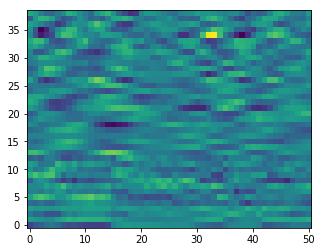

In [4]:
plt.imshow(train_x[0].T, origin="bottom");

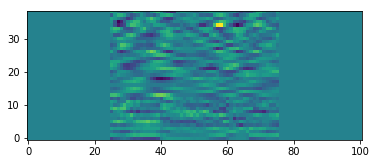

In [5]:
def pad_sequences(x, n_padded, center_padded=True):
    """Return the padded sequences and their original lengths."""
    padded_x = np.zeros((len(x), n_padded, x[0].shape[1]), dtype=NP_DTYPE)
    lengths = []
    for i_data, cur_x in enumerate(x):
        length = cur_x.shape[0]
        if center_padded:
            padding = int(np.round((n_padded - length) / 2.))
            if length <= n_padded:
                padded_x[i_data, padding:padding + length, :] = cur_x
            else:
                # Cut out snippet from sequence exceeding n_padded
                padded_x[i_data, :, :] = cur_x[-padding:-padding + n_padded]
            lengths.append(min(length, n_padded))
        else:
            length = min(length, n_padded)
            padded_x[i_data, :length, :] = cur_x[:length, :]
            lengths.append(length)
    return padded_x, lengths

train_x = train_x[0:2]
train_labels = train_labels[0:2]
train_lengths = train_lengths[0:2]
train_keys = train_keys[0:2]

n_padded = 101
train_x_padded, train_lengths = pad_sequences(train_x, n_padded)

plt.imshow(train_x_padded[0].T, origin="bottom");

In [6]:
train_x = np.array(train_x_padded)
train_x = np.swapaxes(train_x, 2, 1)

# Dimensionalities
d_in = train_x.shape[1]*train_x.shape[2]
input_shape = [-1, train_x.shape[1], train_x.shape[2], 1]  # [n_data, height, width, d_in]
filter_shapes = [
    [13, 27, 1, 3],
    ]
pool_shapes = [
    [1, 3],
    ]

# Flatten data
train_x = train_x.reshape((-1, d_in))

# Model
tf.reset_default_graph()
x = tf.placeholder(TF_DTYPE, [None, d_in])
cnn = tflego.build_cnn(x, input_shape, filter_shapes, pool_shapes=[None], padding="VALID")

def build_conv2d_transpose_relu(x, filter_shape, stride=1, padding="VALID"):
    """Single convolutional layer with bias and ReLU activation."""
    W = tf.get_variable(
        "W", filter_shape, dtype=TF_DTYPE,
        initializer=tf.contrib.layers.xavier_initializer()
        )
    b = tf.get_variable(
        "b", [filter_shape[-1]], dtype=TF_DTYPE,
        initializer=tf.random_normal_initializer()
        )
    x = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)




For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
CNN layer 0 shape: [None, 27, 75, 3]


In [7]:
# TensorFlow graph
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    # Output
    tf_output = cnn.eval({x: train_x})

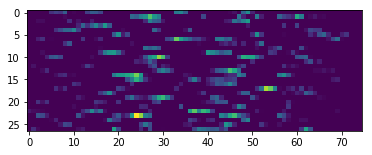

In [8]:
plt.imshow(tf_output[0,:,:,0]);

In [142]:
? tf.nn.conv2d_transpose

## NumPy transpose convolution

In [10]:
def np_conv2d(x, filters, padding="valid"):
    """
    Calculate the convolution of `x` using `filters`.
    
    A useful tutorial: http://www.robots.ox.ac.uk/~vgg/practicals/cnn/.
    
    Parameters
    ----------
    x : matrix [n_data, height, width, d_in]
    filters : matrix [filter_height, filter_width, d_in, d_out]
    """

    import scipy.signal

    # Dimensions
    n_data, height, width, d_in = x.shape
    filter_height, filter_width, _, d_out = filters.shape
    assert d_in == _
    
    # Loop over data
    conv_over_data = []
    for i_data in range(n_data):
        # Loop over output channels
        conv_over_channels = []
        for i_out_channel in range(d_out):
            conv_result = 0.
            # Loop over input channels
            for i_in_channel in range(d_in):
                conv_result += scipy.signal.correlate(
                    x[i_data, :, :, i_in_channel], filters[:, :, i_in_channel,
                    i_out_channel], mode=padding
                    )
            conv_over_channels.append(conv_result)
        conv_over_data.append(
            np.transpose(np.array(conv_over_channels), (1, 2, 0))
            )
    
    return np.array(conv_over_data)

In [201]:
# Test data
n_input = 28*28
n_data = 3
test_data = np.asarray(np.random.randn(n_data, n_input), dtype=NP_DTYPE)


In [202]:
# Test 1
test_data = np.array([[[[4, 5, 8, 7], [1, 8, 8, 8], [3, 6, 6, 4], [6, 5, 7, 8]]]])
test_data = np.transpose(test_data, (0, 2, 3, 1))
W = np.array([[[[1, 4, 1], [1, 4, 3], [3, 3, 1]]]])
W = np.transpose(W, (2, 3, 0, 1))

cnn = np_conv2d(test_data, W)
print(cnn[0, :, :, 0])

[[122. 148.]
 [126. 134.]]


In [203]:
# Test 2
test_data = np.array([[np.ones((4, 4))]])
test_data = np.transpose(test_data, (0, 2, 3, 1))
W = np.array([[np.ones((3, 3))]])
W = np.transpose(W, (2, 3, 0, 1))

print(test_data.shape)
print(W.shape)

cnn = np_conv2d(test_data, W)
print(cnn[0, :, :, 0])

(1, 4, 4, 1)
(3, 3, 1, 1)
[[9. 9.]
 [9. 9.]]


In [204]:
# Test 3
test_data = np.array([[[[1, 3, 2, 1], [1, 3, 3, 1], [2, 1, 1, 3], [3, 2, 3, 3]]]])
test_data = np.transpose(test_data, (0, 2, 3, 1))
W_np = np.array([[[[1, 2, 3], [0, 1, 0], [2, 1, 2]]]])
W_np = np.transpose(W_np, (2, 3, 0, 1))
W_dash = np.rot90(W_np, k=2)

print(test_data.shape)
print(W_np.shape)

cnn = np_conv2d(test_data, W_dash, padding="full")
print(cnn[0, :, :, 0])

(1, 4, 4, 1)
(3, 3, 1, 1)
[[ 1.  5. 11. 14.  8.  3.]
 [ 1.  6. 15. 18. 12.  3.]
 [ 4. 13. 21. 21. 15. 11.]
 [ 5. 17. 28. 27. 25. 11.]
 [ 4.  7.  9. 12.  8.  6.]
 [ 6.  7. 14. 13.  9.  6.]]


In [249]:
# TensorFlow
input_shape = [1, 4, 4, 1]
filter_shape = [3, 3, 1, 1]
n_input = input_shape[0]*input_shape[1]
output_shape = [1, input_shape[1] + filtershape[0] - 1, input_shape[2] + filtershape[1] - 1, 1]

stride = 1
x = tf.placeholder(TF_DTYPE, [None, n_input])
W = tf.placeholder(TF_DTYPE, filter_shape)
x = tf.reshape(x, input_shape)
conv_transpose = tf.nn.conv2d_transpose(x, W, output_shape, strides=[1]*4, padding="VALID")

def build_unmaxpool2d(x, pool_shape):
    """
    Unpool by repeating units.
    
    See:
    - https://github.com/keras-team/keras/issues/378
    - https://swarbrickjones.wordpress.com/2015/04/29
    """
    from tensorflow.keras.backend import repeat_elements
    s1 = pool_shape[0]
    s2 = pool_shape[1]
    return repeat_elements(repeat_elements(x, s1, axis=1), s2, axis=2)
    
unpooled = build_unmaxpool2d(conv_transpose, pool_shape=(2, 2))

# cnn = tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding=padding)

In [250]:
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    # Output
    tf_output = conv_transpose.eval({x: test_data, W: W_np})
    tf_output2 = unpooled.eval({x: test_data, W: W_np})

In [254]:
tf_output[0, :, :, 0]

array([[ 1.,  5., 11., 14.,  8.,  3.],
       [ 1.,  6., 15., 18., 12.,  3.],
       [ 4., 13., 21., 21., 15., 11.],
       [ 5., 17., 28., 27., 25., 11.],
       [ 4.,  7.,  9., 12.,  8.,  6.],
       [ 6.,  7., 14., 13.,  9.,  6.]], dtype=float32)

In [253]:
tf_output2[0, :, :, 0]

array([[ 1.,  1.,  5.,  5., 11., 11., 14., 14.,  8.,  8.,  3.,  3.],
       [ 1.,  1.,  5.,  5., 11., 11., 14., 14.,  8.,  8.,  3.,  3.],
       [ 1.,  1.,  6.,  6., 15., 15., 18., 18., 12., 12.,  3.,  3.],
       [ 1.,  1.,  6.,  6., 15., 15., 18., 18., 12., 12.,  3.,  3.],
       [ 4.,  4., 13., 13., 21., 21., 21., 21., 15., 15., 11., 11.],
       [ 4.,  4., 13., 13., 21., 21., 21., 21., 15., 15., 11., 11.],
       [ 5.,  5., 17., 17., 28., 28., 27., 27., 25., 25., 11., 11.],
       [ 5.,  5., 17., 17., 28., 28., 27., 27., 25., 25., 11., 11.],
       [ 4.,  4.,  7.,  7.,  9.,  9., 12., 12.,  8.,  8.,  6.,  6.],
       [ 4.,  4.,  7.,  7.,  9.,  9., 12., 12.,  8.,  8.,  6.,  6.],
       [ 6.,  6.,  7.,  7., 14., 14., 13., 13.,  9.,  9.,  6.,  6.],
       [ 6.,  6.,  7.,  7., 14., 14., 13., 13.,  9.,  9.,  6.,  6.]],
      dtype=float32)

In [197]:
# Test 4

def get_conv2d_transpose_output_shape(input_shape, filter_shape, stride=1):
    """
    Calculate the output shape of a transposed convolution operation.
    
    See https://stackoverflow.com/questions/46885191/tf-nn-conv2d-transpose-output-shape-dynamic-batch-size
    
    Parameters
    ----------
    input_shape : list
        The shape of the input to the CNN as [n_data, height, width, d_in].
    filter_shape : list of list
        The filter shape of each layer as [height, width, d_out, d_in].
    """
    input_height = input_shape[1]
    input_width = input_shape[2]
    filter_height = filter_shape[0]
    filter_width = filter_shape[1]
    output_height = (input_height - 1)*stride + filter_height
    output_width = (input_width - 1)*stride + filter_width
    return [input_shape[0], output_height, output_width, filter_shape[2]]    
    

def build_conv2d_transpose(x, filter_shape, stride=1, activation=tf.nn.relu):
    """Single transposed convolutional layer."""
    W = tf.get_variable(
        "W", filter_shape, dtype=TF_DTYPE,
        initializer=tf.contrib.layers.xavier_initializer()
        )
    b = tf.get_variable(
        "b", [filter_shape[-2]], dtype=TF_DTYPE,
        initializer=tf.random_normal_initializer()
        )
    input_shape = x.get_shape().as_list()
    output_shape = get_conv2d_transpose_output_shape(
        x.get_shape().as_list(), W.get_shape().as_list()
        )
    output_shape[0] = tf.shape(x)[0]
    x = tf.nn.conv2d_transpose(x, W, output_shape, strides=[1, stride, stride, 1], padding="VALID")
    x = tf.nn.bias_add(x, b)
    return activation(x)
    
tf.reset_default_graph()

# Random seed
np.random.seed(1)
tf.set_random_seed(1)

# Test data
n_input = 4*4*5
n_data = 2
test_data = np.asarray(np.random.randn(n_data, n_input), dtype=NP_DTYPE)

# Model parameters
input_shape = [-1, 4, 4, 5]  # [n_data, height, width, d_in]
filter_shape = [3, 3, 2, 5]  # [filter_height, filter_width, d_out, d_in]

# TensorFlow model
x = tf.placeholder(TF_DTYPE, [None, n_input])
x_reshaped = tf.reshape(x, input_shape)
i_layer = 0
with tf.variable_scope("cnn_transpose_layer_{}".format(i_layer)):
    conv_transpose = build_conv2d_transpose(x_reshaped, filter_shape, activation=tf.identity)
with tf.variable_scope("cnn_transpose_layer_0", reuse=True):
    W_0 = tf.get_variable("W")
    b_0 = tf.get_variable("b")

# TensorFlow graph
init = tf.global_variables_initializer()
with tf.Session() as session:
    session.run(init)

    # Output
    tf_output = conv_transpose.eval({x: test_data})

    # Parameters
    W_0 = W_0.eval()
    b_0 = b_0.eval()

In [198]:
# Numpy model
x_np = test_data.reshape(input_shape)
W_dash = np.rot90(W_0, k=2)
W_dash = np.transpose(W_dash, (0, 1, 3, 2))
np_output = np_conv2d(x_np, W_dash, padding="full") + b_0

import numpy.testing as npt
npt.assert_almost_equal(tf_output, np_output, decimal=5)